In [12]:
import h5py
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
import H5pyHelper
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.inception_v3 import InceptionV3
#import dask.array as da
#from dask.array.slicing import shuffle_slice
import cv2
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
BATCH_SIZE = 32


Num GPUs Available:  1


In [14]:
df = pd.read_csv("clean_data/image_paths.csv")

## get all unique labels and sort them (for classification_report)
inps = list(df['label'].unique())
inps.sort()
print(inps)

# shuffle dataframe
df = df.sample(frac=1)


# stratify ensures that train validate and test sets have approximately the same percentage of samples of each target class as the complete set
# more info here: https://stats.stackexchange.com/questions/250273/benefits-of-stratified-vs-random-sampling-for-generating-training-data-in-classi
# this is good because we have some data that is not evenly represented in the dataset which leads to poor performance if not evenly distributed in training/validating/testing
train,test = train_test_split(df, test_size=0.1, random_state=1,stratify=df['label'])
train,validate = train_test_split(train, test_size=0.111, random_state=1,stratify=train['label']) # 0.25 x 0.8 = 0.2

image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    rescale= 1.0/255.0,
    rotation_range=30
    )

test_image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0,
    )

train_iterator = image_datagen.flow_from_dataframe(train,x_col="image-path",y_col="label",batch_size=BATCH_SIZE,target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

batch_x,batch_y = train_iterator.next()
NUM_CLASSES = batch_y.shape[1]

validate_iterator = image_datagen.flow_from_dataframe(validate,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

test_iterator = test_image_datagen.flow_from_dataframe(test,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical")

['Abronia elliptica', 'Abronia fragrans', 'Abronia nana', 'Achillea millefolium', 'Aconitum columbianum', 'Actaea rubra', 'Agastache urticifolia', 'Agoseris aurantiaca', 'Agoseris glauca', 'Aliciella pinnatifida', 'Alisma triviale', 'Allionia incarnata', 'Allium acuminatum', 'Allium cernuum', 'Allium geyeri', 'Allium macropetalum', 'Allium schoenoprasum', 'Alyssum simplex', 'Amauriopsis dissecta', 'Amelanchier utahensis', 'Anagallis arvensis', 'Anaphalis margaritacea', 'Androsace septentrionalis', 'Androstephium breviflorum', 'Anemone multifida', 'Anemone narcissiflora', 'Anemone patens', 'Anemopsis californica', 'Antennaria anaphaloides', 'Antennaria dimorpha', 'Antennaria media', 'Antennaria parvifolia', 'Antennaria rosea', 'Antennaria umbrinella', 'Anthemis cotula', 'Anticlea elegans', 'Apocynum androsaemifolium', 'Apocynum cannabinum', 'Aquilegia caerulea', 'Aquilegia chrysantha', 'Aquilegia elegantula', 'Arctium minus', 'Arctostaphylos patula', 'Arenaria lanuginosa', 'Argemone pol

In [15]:
## modified code from https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50
def get_class_counts(df):
    grp = df.groupby(['label']).nunique()

    return grp.to_dict()['image-path']
def get_class_proportions(df):
    class_counts = get_class_counts(df)
    return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

print(get_class_counts(test)['Astragalus lentiginosus'])

20


In [16]:
## alex net
#model = models.Sequential([
#    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
#    layers.BatchNormalization(),
#    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#    layers.BatchNormalization(),
#    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    layers.BatchNormalization(),
#    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", kernel_regularizer=tf.keras.regularizers.l2(l=0.04)),
#    layers.BatchNormalization(),
#    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#    layers.BatchNormalization(),
#    layers.Flatten(),
#    #layers.Dense(1024, activation='relu'),
#    #layers.Dropout(0.5),
#    layers.Dense(1024, activation='relu'),
#    layers.Dropout(0.7),
#    layers.Dense(NUM_CLASSES, activation='softmax')
#])

# we do not want the default output layer
#model = VGG16(include_top=False, input_shape=(256,256,3))
#model = InceptionV3(include_top=False, input_shape=(256,256,3), weights='imagenet')
model = ResNet50(include_top=False, input_shape=(256,256,3))

#for layer in model.layers:
    #layer.trainable = False

# mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False
flat1 = layers.Flatten()(model.output)

#layers.Dense(1024, activation='relu'),
#layers.Dropout(0.5),
class1 = layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.04))(flat1)
layers.Dropout(0.7),
output = layers.Dense(NUM_CLASSES, activation='softmax')(class1)

model = tf.keras.Model(inputs=model.inputs, outputs = output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.0001), metrics=['accuracy'])

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
fit = model.fit(x=train_iterator,
                steps_per_epoch= len(train_iterator),
                #callbacks=[callback], 
                validation_steps= len(validate_iterator),
                validation_data=validate_iterator,
                verbose=1,
                epochs=50)

Epoch 1/50
357/357 [==============================] - 117s 319ms/step - loss: 86.0420 - accuracy: 0.0297 - val_loss: 85.9036 - val_accuracy: 0.0140
Epoch 2/50
357/357 [==============================] - 115s 320ms/step - loss: 84.7220 - accuracy: 0.0963 - val_loss: 84.5164 - val_accuracy: 0.0877
Epoch 3/50
357/357 [==============================] - 116s 326ms/step - loss: 83.7625 - accuracy: 0.1713 - val_loss: 83.4314 - val_accuracy: 0.1902
Epoch 4/50
357/357 [==============================] - 115s 323ms/step - loss: 82.9073 - accuracy: 0.2388 - val_loss: 82.6743 - val_accuracy: 0.2302
Epoch 5/50
357/357 [==============================] - 115s 322ms/step - loss: 82.1051 - accuracy: 0.2986 - val_loss: 82.0113 - val_accuracy: 0.2835
Epoch 6/50
357/357 [==============================] - 114s 319ms/step - loss: 81.3786 - accuracy: 0.3520 - val_loss: 81.3486 - val_accuracy: 0.3263
Epoch 7/50
357/357 [==============================] - 125s 351ms/step - loss: 80.6951 - accuracy: 0.4001 - val_l

In [ ]:
# get all test labels from dataframe
y_true = []

# get all true labels
for i in range(len(test_iterator)):
    batch_x,batch_y = test_iterator.next()
    batch_y = list(batch_y)
    y_true += batch_y

#print(y_true)
# get test predictions
y_pred = model.predict(x = test_iterator,
                    steps = len(test_iterator),
                    batch_size=BATCH_SIZE,
                    verbose=1)

# convert one hot to max index
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

print(accuracy_score(y_true,y_pred) * 100, "%")

# have to include labels parameter because test set does not have all of the classes from inps
matrix = classification_report(y_true,y_pred,labels=np.arange(len(inps)),target_names =inps)
print('Classification report: \n',matrix)




45/45 [==============================] - 4s 68ms/step
1.4716187806587244 %
Classification report: 
                            precision    recall  f1-score   support

        Abronia elliptica       0.00      0.00      0.00        20
         Abronia fragrans       0.00      0.00      0.00        20
             Abronia nana       0.00      0.00      0.00         6
     Achillea millefolium       0.00      0.00      0.00        20
     Aconitum columbianum       0.05      0.10      0.07        20
             Actaea rubra       0.00      0.00      0.00        20
    Agastache urticifolia       0.08      0.05      0.06        20
      Agoseris aurantiaca       0.00      0.00      0.00        20
          Agoseris glauca       0.00      0.00      0.00        20
    Aliciella pinnatifida       0.00      0.00      0.00         8
          Alisma triviale       0.00      0.00      0.00        20
       Allionia incarnata       0.00      0.00      0.00        20
        Allium acuminatum   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('model/')

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model/') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: model/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


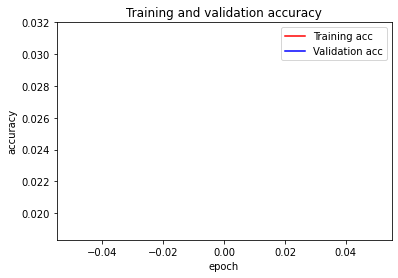

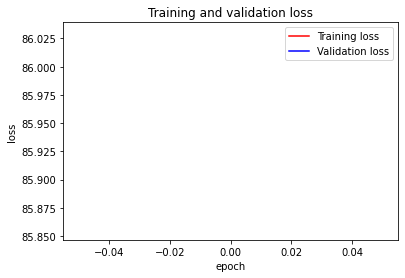

In [ ]:
import matplotlib.pyplot as plt 
#Graphing our training and validation
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

Normalized confusion matrix


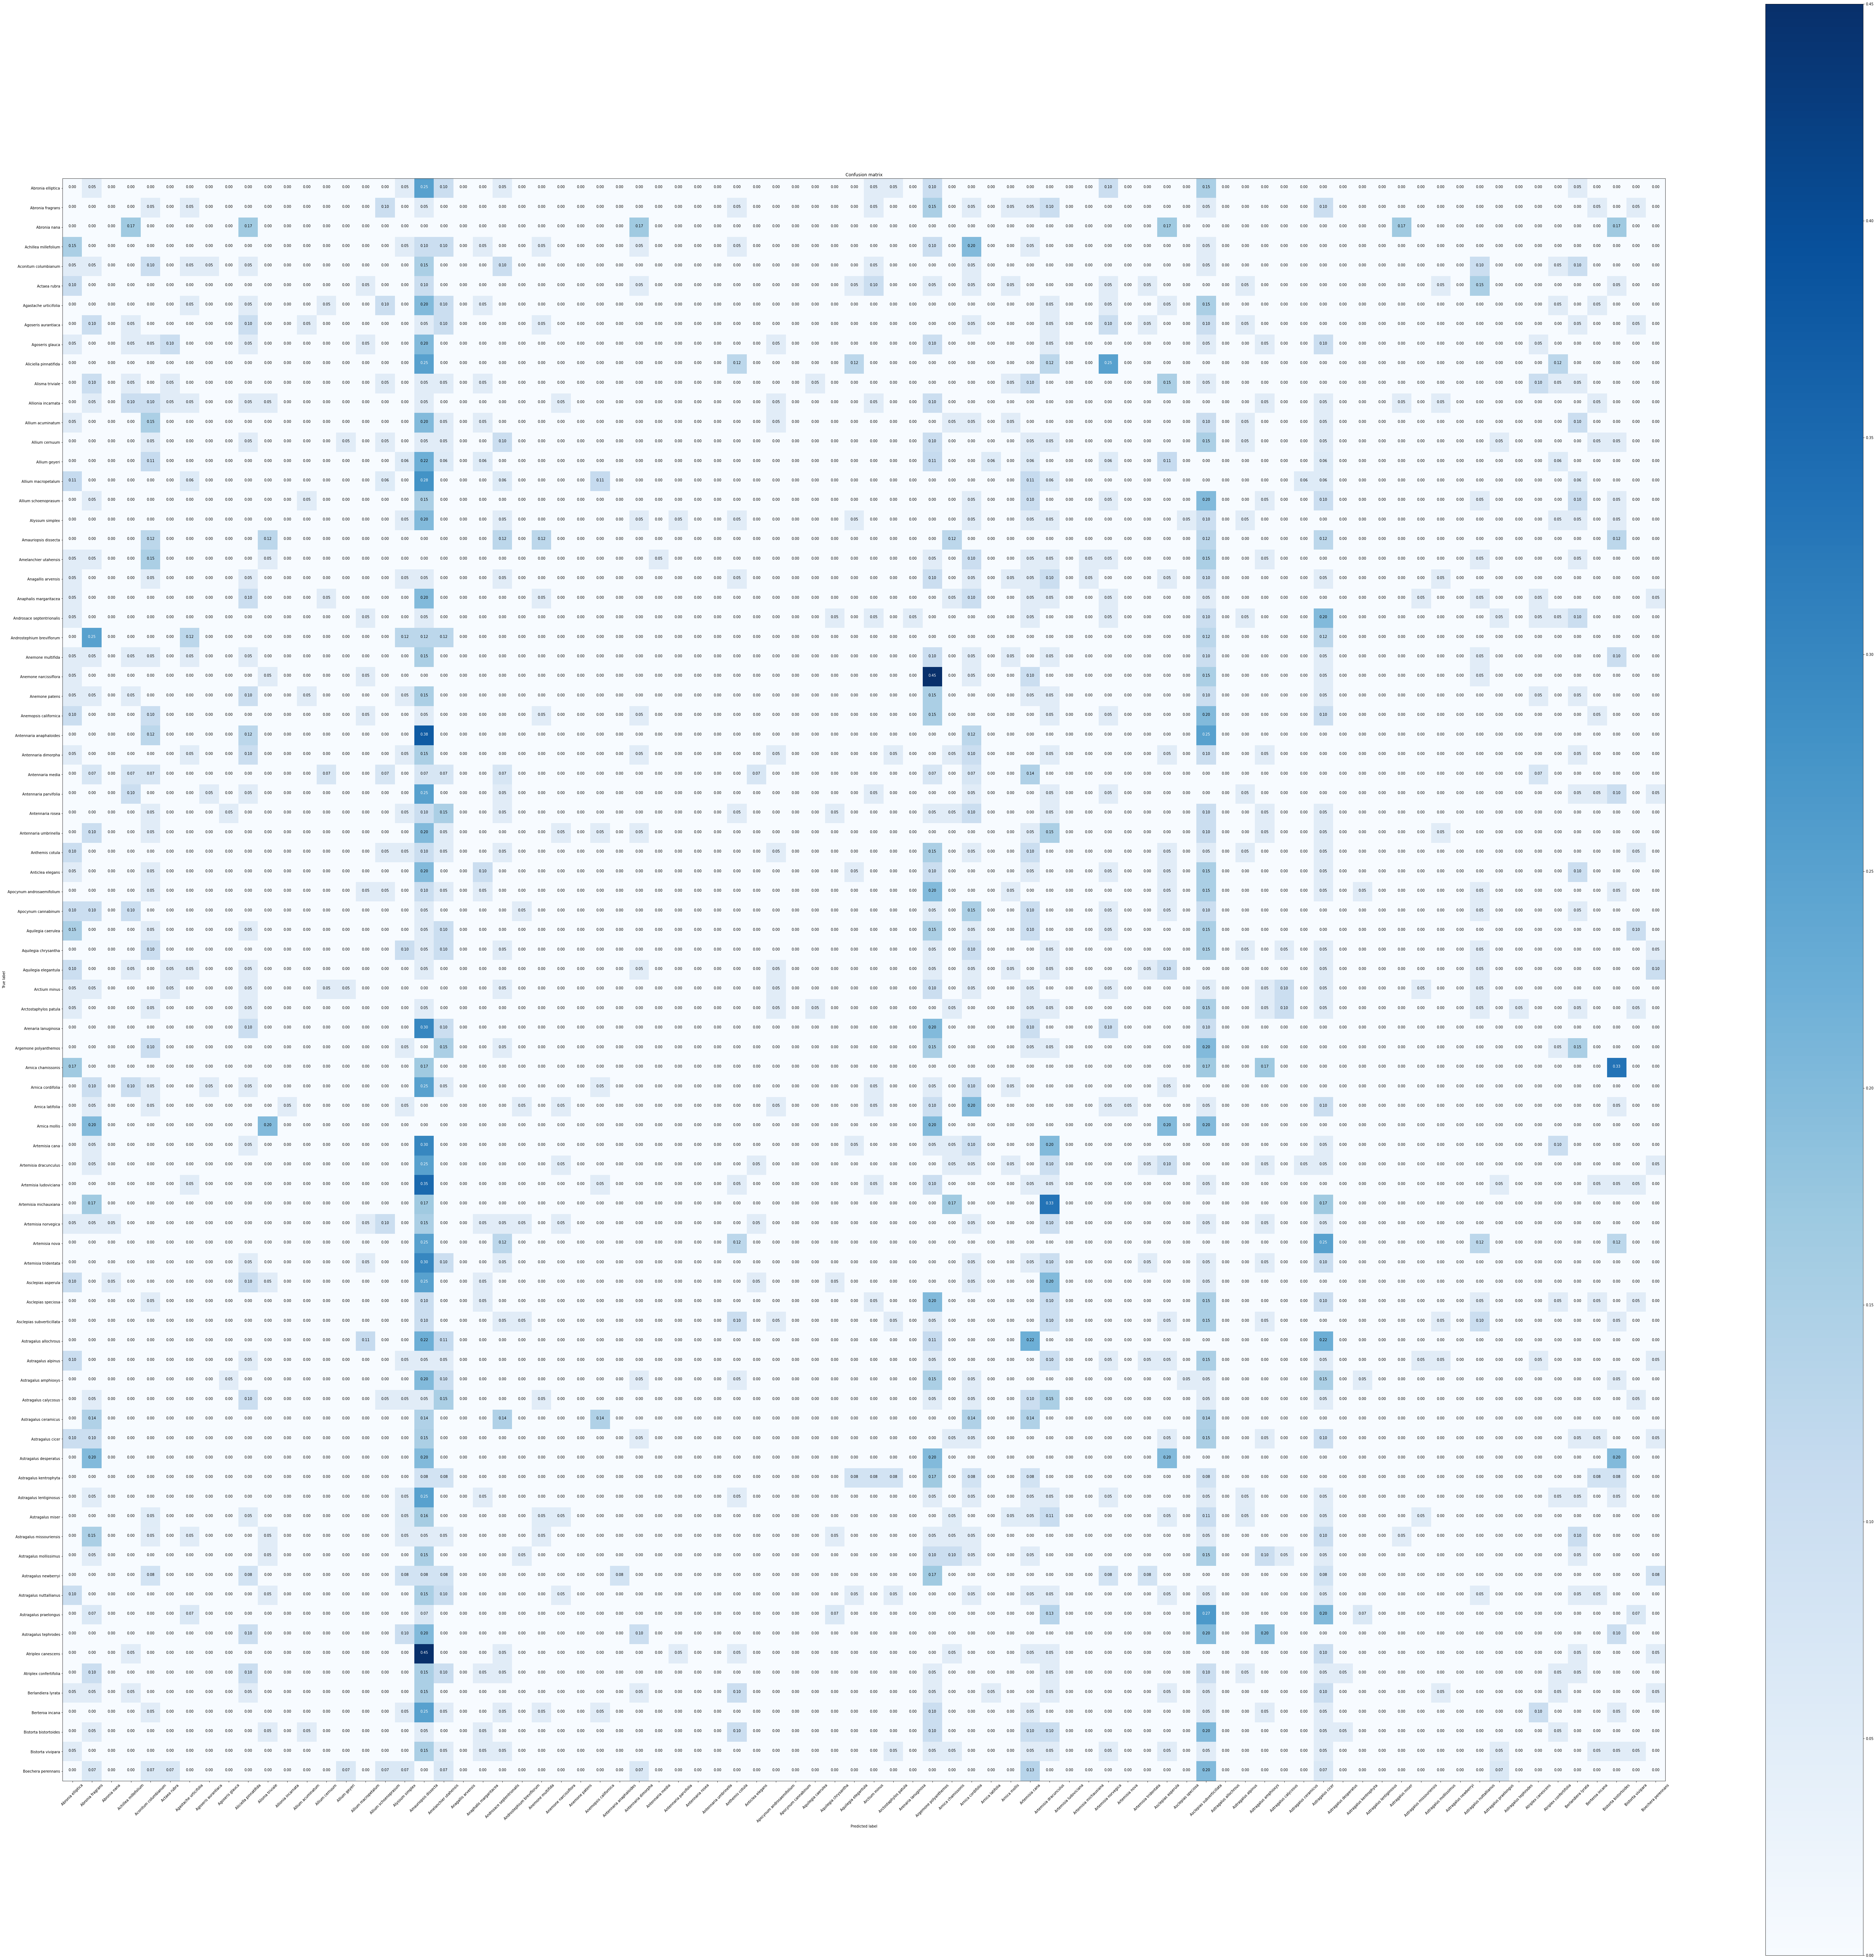

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# grabbed from here: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
confusion_matrix = confusion_matrix(y_true,y_pred)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
 
    plt.figure(figsize=(100,100))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

plot_confusion_matrix(confusion_matrix,inps,normalize=True)